In [1]:
import sys
import numpy as np
from astropy.io import fits
from aspired import image_reduction
from aspired import spectral_reduction

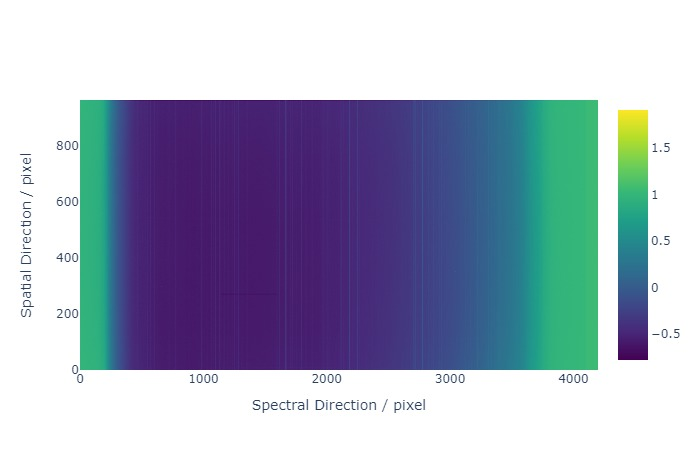

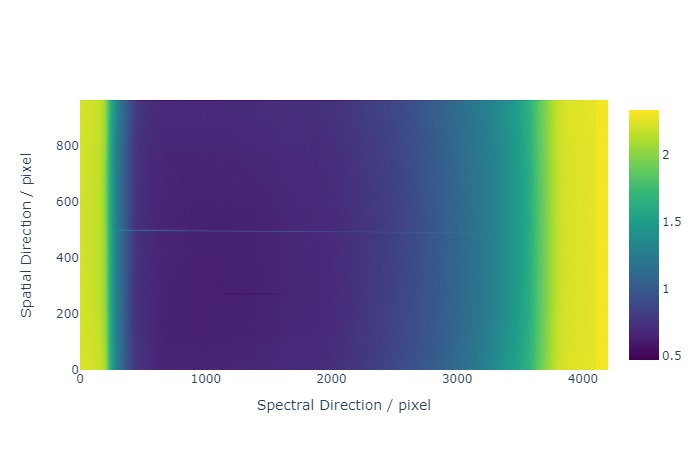

In [2]:
# Set the spectral and spatial direction
Saxis = 0

science_frame = image_reduction.ImageReduction('isis_pso1801p6254.list', cosmicray=True, fsmode='median', saxis=Saxis)
science_frame.reduce()
science_frame.inspect(renderer='jpg', filename='reduced_image_pso1801p6254', save_fig=True)
#science_frame.savefits(overwrite=True)

standard_frame = image_reduction.ImageReduction('isis_g93m48.list', saxis=Saxis)
standard_frame.reduce()
standard_frame.inspect(renderer='jpg', filename='reduced_image_g93m48', save_fig=True)

In [3]:
# spec mask
spatial_mask = np.arange(475, 575)
spec_mask = np.arange(200, 4000)

# initialise the two spectral_reduction.TwoDSpec()
pso = spectral_reduction.TwoDSpec(
    science_frame,
    spatial_mask=spatial_mask,
    spec_mask=spec_mask,
    readnoise=4.5,
    cosmicray=False,
    gain=0.98,
    seeing=1.1,
    verbose=False
)
g93 = spectral_reduction.TwoDSpec(
    standard_frame,
    spatial_mask=spatial_mask,
    spec_mask=spec_mask,
    readnoise=4.5,
    cosmicray=False,
    gain=0.98,
    seeing=1.1,
    verbose=False
)

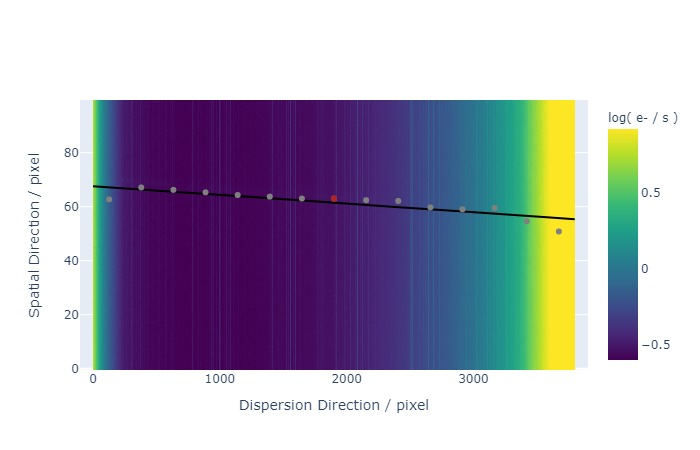

61.447670508228846
1.9573491483281444


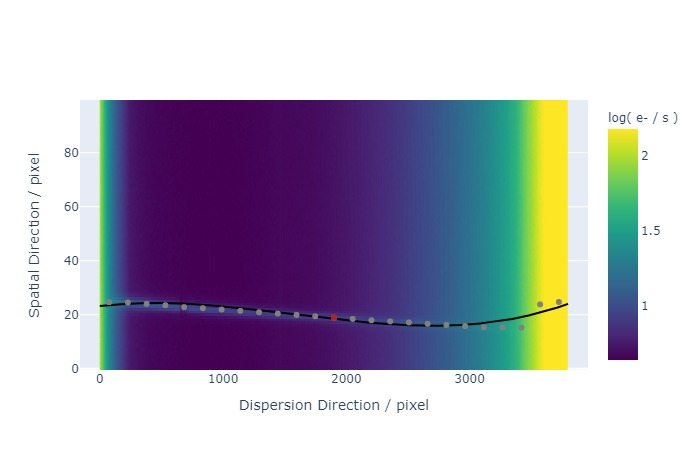

20.077909453300016
4.921779163278876


In [4]:
# automatically trace the spectrum
pso.ap_trace(display=True, nwindow=15, percentile=40, shift_tol=5., ap_faint=20, fit_deg=1, renderer='jpg', save_fig=True, filename='pso_trace')
print(np.nanmean(pso.spectrum_list[0].trace))
print(np.nanmean(pso.spectrum_list[0].trace_sigma))

g93.ap_trace(display=True, renderer='jpg', save_fig=True, filename='g93_trace')
print(np.nanmean(g93.spectrum_list[0].trace))
print(np.nanmean(g93.spectrum_list[0].trace_sigma))

c:\users\cylam\git\aspired\aspired\twodspec.py:3319: RuntimeWarning:

invalid value encountered in double_scalars



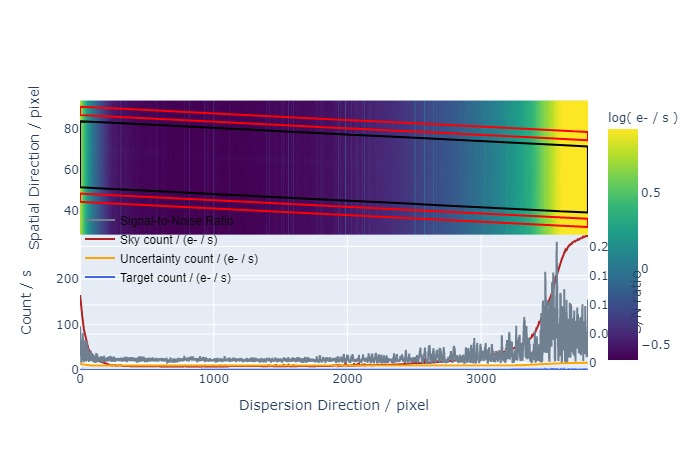

c:\users\cylam\git\aspired\aspired\twodspec.py:3305: RuntimeWarning:

divide by zero encountered in true_divide

c:\users\cylam\git\aspired\aspired\twodspec.py:3275: RuntimeWarning:

invalid value encountered in true_divide

c:\users\cylam\git\aspired\aspired\twodspec.py:3314: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\cylam\git\aspired\aspired\twodspec.py:3317: RuntimeWarning:

invalid value encountered in double_scalars



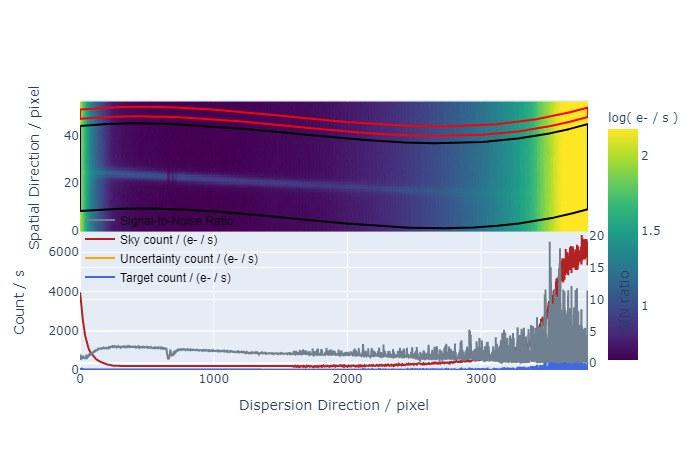

In [5]:
pso.spectrum_list[0].trace_sigma = g93.spectrum_list[0].trace_sigma

# Optimal extracting spectrum by summing over the aperture along the trace
pso.ap_extract(
    apwidth=15,
    optimal=True,
    model='gauss',
    display=True,
    renderer='jpg',
    save_fig=True,
    filename='pso_extract')
g93.ap_extract(
    apwidth=20,
    skysep=3,
    skywidth=5,
    skydeg=1,
    optimal=True,
    display=True,
    renderer='jpg',
    save_fig=True,
    filename='g93_extract')

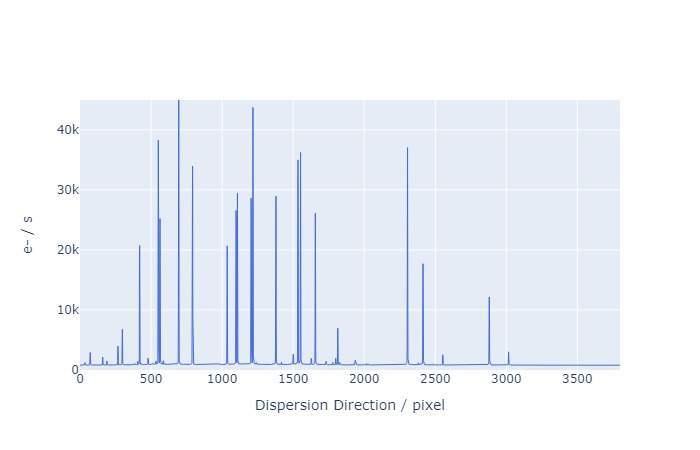

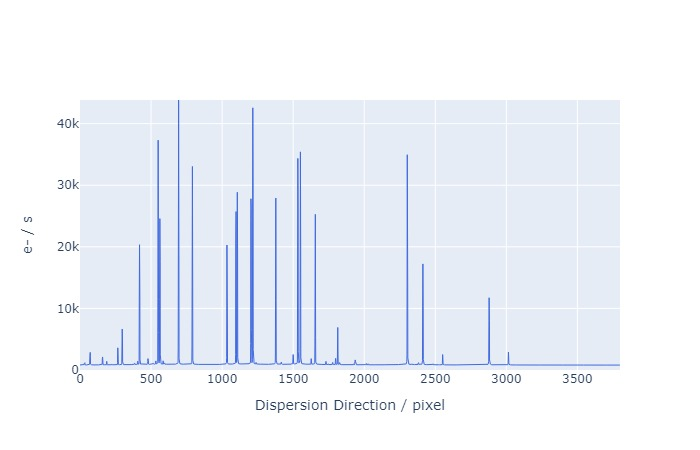

In [6]:
pso.extract_arc_spec(
    display=True,
    renderer='jpg',
    save_fig=True,
    filename='arc_spec_science')
g93.extract_arc_spec(
    display=True,
    renderer='jpg',
    save_fig=True,
    filename='arc_spec_standard')
    

In [7]:
pso_reduced = spectral_reduction.OneDSpec()
pso_reduced.from_twodspec(pso, stype='science')
pso_reduced.from_twodspec(g93, stype='standard')

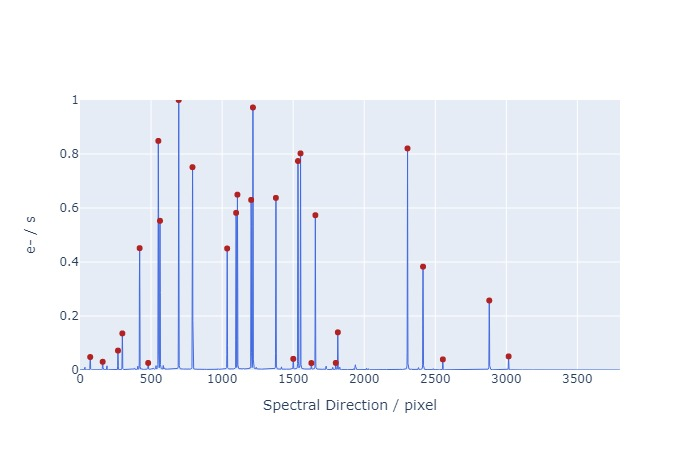

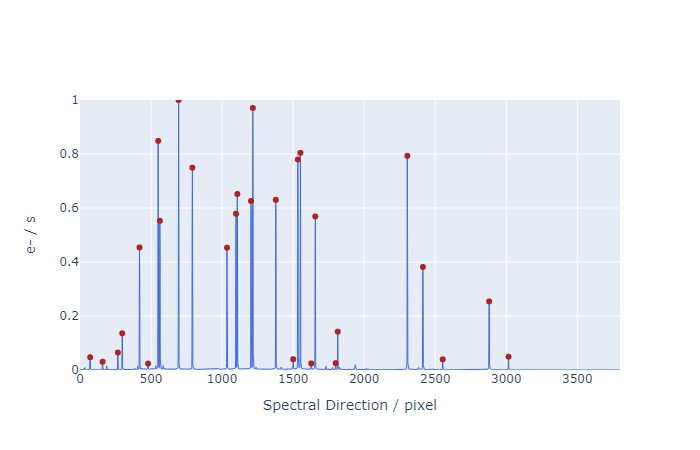

In [8]:
pso_reduced.find_arc_lines(
    prominence=2.,
    display=True,
    stype='science+standard',
    renderer='jpg',
    save_fig=True,
    filename='arc_lines')

In [9]:
pso_reduced.initialise_calibrator(stype='science+standard')
pso_reduced.set_hough_properties(
    num_slopes=2000,
    xbins=200,
    ybins=200,
    min_wavelength=7000.,
    max_wavelength=11000.,
    stype='science+standard')
pso_reduced.add_atlas(
    elements=["Cu", "Ne", 'Ar'],
    min_atlas_wavelength=7000.,
    max_atlas_wavelength=11000.,
    stype='science+standard')
pso_reduced.do_hough_transform(brute_force=False)

In [10]:
pso_reduced.fit(
    max_tries=1000,
    fit_tolerance=5.,
    display=True,
    save_fig=True,
    fig_type='iframe+png',
    stype='science+standard')

Most inliers: 13, best error: 0.2107: 100%|██████████| 1000/1000 [00:32<00:00, 31.17it/s]


Most inliers: 15, best error: 0.1245: 100%|██████████| 1000/1000 [00:18<00:00, 54.62it/s]


In [11]:
pso_reduced.apply_wavelength_calibration(stype='science+standard')


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



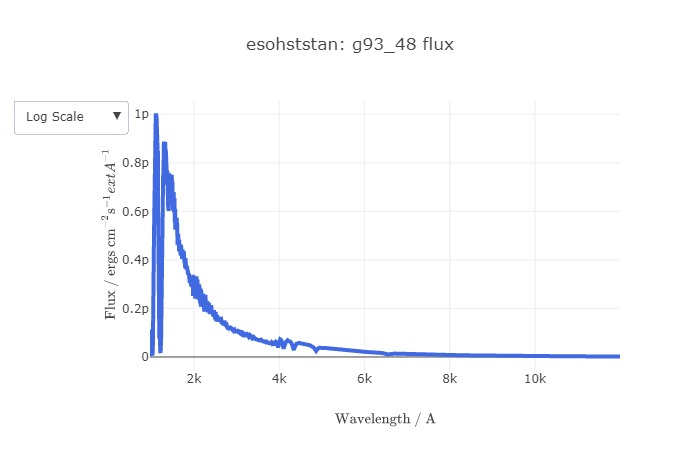

In [12]:
pso_reduced.load_standard(
    target='g93_48',
    library='esohststan',
    cutoff=0.4,
)
pso_reduced.inspect_standard(renderer='jpg', save_fig=True, filename='literature_standard')


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



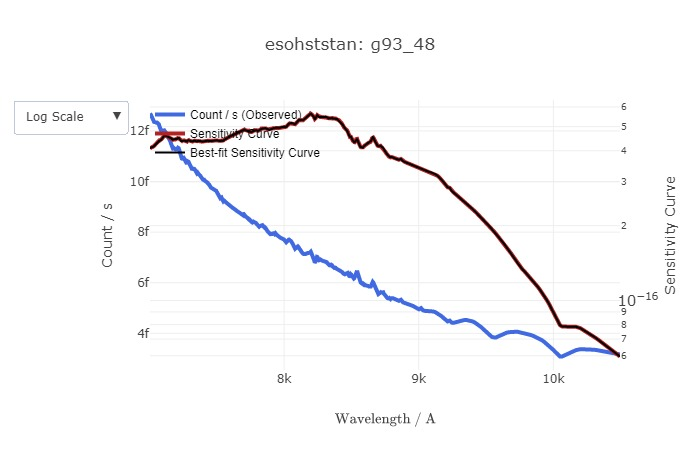

In [13]:
pso_reduced.compute_sensitivity()
pso_reduced.inspect_sensitivity(renderer='jpg', save_fig=True, filename='sensitivity')

In [14]:
pso_reduced.apply_flux_calibration(stype='science+standard')


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

In [15]:
pso_reduced.inspect_reduced_spectrum(
    wave_min=7000.,
    wave_max=10500.,
    stype='science',
    save_fig=True,
    filename='pso_reduced_spectrum')

In [16]:
pso_reduced.inspect_reduced_spectrum(
    wave_min=7000.,
    wave_max=10500.,
    stype='standard',
    save_fig=True,
    filename='g93_reduced_spectrum')